## Imports

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import missingno as msno
from keras.models import Model, Sequential
from keras.layers import LSTM, Input, Dense, concatenate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error

## configs and methods

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

## Checking data completness

In [3]:
os.listdir('./data')

['bundesliga', 'la liga', 'ligue 1', 'premier league', 'serie a']

In [4]:
def check_columns():
    first_file_cols = None

    for folder in os.listdir('./data'):
        for file in os.listdir(f'./data/{folder}'):
            data = pd.read_csv(f'./data/{folder}/{file}')
            num_of_cols = data.shape[1]

            if first_file_cols is None:
                first_file_cols = num_of_cols
            elif first_file_cols != num_of_cols:
                return 'There is some mismatch somewhere in csvs'
    
    return 'Number of columns are matching'

In [5]:
check_columns()

'Number of columns are matching'

## Data joining

In [115]:
data = pd.DataFrame()

for folder in os.listdir('./data'):
    for file in os.listdir(f'./data/{folder}'):
        df = pd.read_csv(f'./data/{folder}/{file}')
        data = pd.concat([data, df], ignore_index=True)

## Basic data description

In [7]:
data.shape

(25945, 66)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25945 entries, 0 to 25944
Data columns (total 66 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   timestamp                            25945 non-null  int64  
 1   date_GMT                             25945 non-null  object 
 2   status                               25945 non-null  object 
 3   attendance                           20594 non-null  float64
 4   home_team_name                       25945 non-null  object 
 5   away_team_name                       25945 non-null  object 
 6   referee                              16175 non-null  object 
 7   Game Week                            25184 non-null  float64
 8   Pre-Match PPG (Home)                 25945 non-null  float64
 9   Pre-Match PPG (Away)                 25945 non-null  float64
 10  home_ppg                             25945 non-null  float64
 11  away_ppg                    

In [9]:
data.head()

,timestamp,date_GMT,status,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_goal_timings,away_team_goal_timings,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name
0,1249669800,Aug 07 2009 - 6:30pm,complete,NaN,Wolfsburg,Stuttgart,Felix Brych,1.0,0.0,0.0,1.35,1.53,2,0,2,0,0,0,"71,82",NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,VOLKSWAGEN ARENA (Wolfsburg)
1,1249738200,Aug 08 2009 - 1:30pm,complete,NaN,Borussia Dortmund,Köln,Wolfgang Stark,1.0,0.0,0.0,2.00,1.35,1,0,1,0,0,0,75,NaN,-1,-1,0,0,1,0,0,0,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Signal-Iduna-Park (Dortmund)
2,1249738200,Aug 08 2009 - 1:30pm,complete,NaN,Nürnberg,Schalke 04,Knut Kircher,1.0,0.0,0.0,1.12,1.76,1,2,3,1,0,1,88,"36,50",-1,-1,2,0,1,0,1,1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Max-Morlock-Stadion (Nürnberg)
3,1249738200,Aug 08 2009 - 1:30pm,complete,NaN,Werder Bremen,Eintracht Frankfurt,NaN,1.0,0.0,0.0,1.76,1.18,2,3,5,4,2,2,"13,44","6,42,71",-1,-1,2,1,2,0,1,2,0,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wohninvest WESERSTADION (Bremen)
4,1249738200,Aug 08 2009 - 1:30pm,complete,NaN,Hertha BSC,Hannover 96,Guido Winkmann,1.0,0.0,0.0,0.53,0.82,1,0,1,0,0,0,82,NaN,-1,-1,3,0,2,0,0,3,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Olympiastadion Berlin (Berlin)


## Empties

In [10]:
pd.DataFrame({
    'ilość braków danych': data.isna().sum(),
    'procentowa ilość braków danych': data.isna().sum() / len(data)
})

,ilość braków danych,procentowa ilość braków danych
timestamp,0,0.000000
date_GMT,0,0.000000
status,0,0.000000
attendance,5351,0.206244
home_team_name,0,0.000000
away_team_name,0,0.000000
referee,9770,0.376566
Game Week,761,0.029331
Pre-Match PPG (Home),0,0.000000
Pre-Match PPG (Away),0,0.000000


<Axes: >

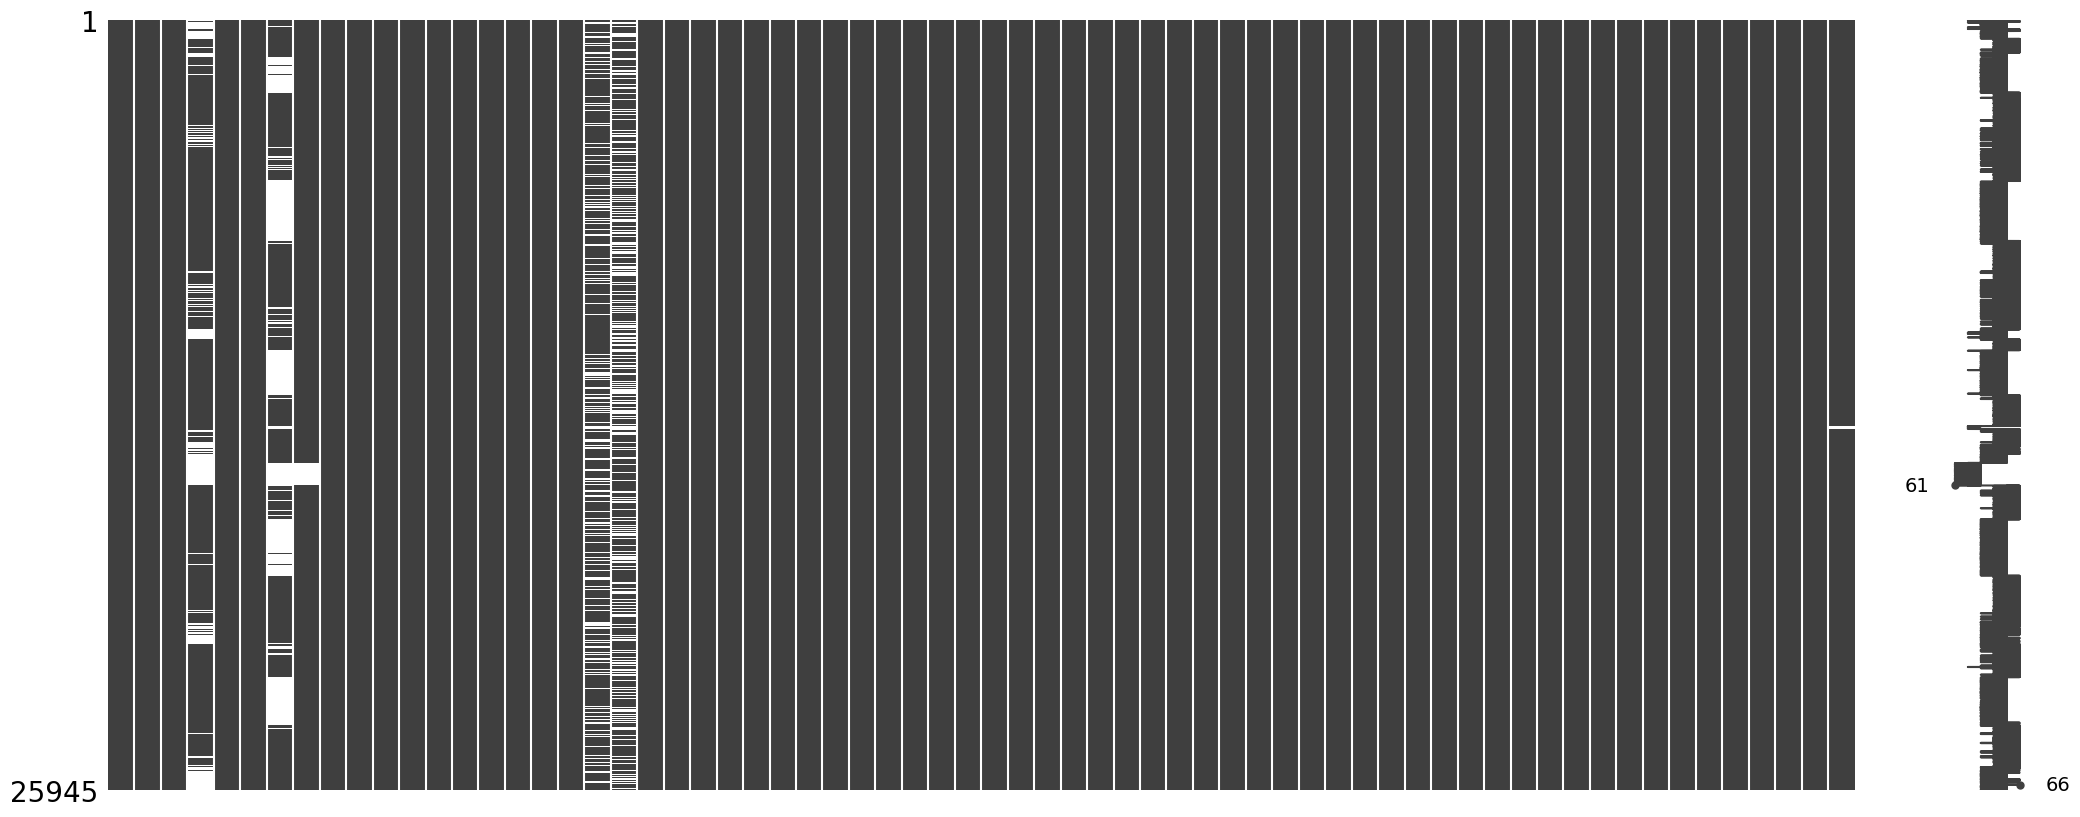

In [29]:
msno.matrix(data)

## uniques

In [10]:
data.nunique()

timestamp                              13306
date_GMT                               13306
status                                     2
attendance                             12871
home_team_name                           184
away_team_name                           184
referee                                  274
Game Week                                 38
Pre-Match PPG (Home)                     213
Pre-Match PPG (Away)                     219
home_ppg                                  92
away_ppg                                  97
home_team_goal_count                      11
away_team_goal_count                      10
total_goal_count                          13
total_goals_at_half_time                   8
home_team_goal_count_half_time             7
away_team_goal_count_half_time             7
home_team_goal_timings                  8747
away_team_goal_timings                  6471
home_team_corner_count                    23
away_team_corner_count                    21
home_team_

In [13]:
data.select_dtypes(exclude='object').dtypes

timestamp                                int64
attendance                             float64
Game Week                              float64
Pre-Match PPG (Home)                   float64
Pre-Match PPG (Away)                   float64
home_ppg                               float64
away_ppg                               float64
home_team_goal_count                     int64
away_team_goal_count                     int64
total_goal_count                         int64
total_goals_at_half_time                 int64
home_team_goal_count_half_time           int64
away_team_goal_count_half_time           int64
home_team_corner_count                   int64
away_team_corner_count                   int64
home_team_yellow_cards                   int64
home_team_red_cards                      int64
away_team_yellow_cards                   int64
away_team_red_cards                      int64
home_team_first_half_cards               int64
home_team_second_half_cards              int64
away_team_fir

In [32]:
data.select_dtypes(exclude='object').corr().style.background_gradient()

,attendance,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no
attendance,1.000000,-0.055241,0.315136,0.024869,0.471860,0.009719,0.197326,-0.070443,0.105092,0.073509,0.143305,-0.054486,0.084790,-0.076063,-0.089734,-0.011457,0.006848,-0.003215,-0.067929,-0.058361,0.010713,-0.000911,0.051615,-0.124104,0.122378,-0.049946,-0.021826,-0.144599,-0.100645,-0.051376,0.053054,-0.116840,-0.077557,-0.133514,-0.064356,-0.147750,0.107503,-0.004938,0.065510,0.111862,0.117007,0.099178,0.083882,0.052155,0.094666,0.047317,0.062805,-0.154472,0.008270,0.130447,0.075075,-0.169637,-0.129904,-0.194736,-0.198009,-0.148433,-0.138483
Game Week,-0.055241,1.000000,0.205572,0.117303,0.000348,-0.002494,0.008212,-0.001650,0.005249,0.003165,0.006588,-0.002813,-0.007540,-0.008806,-0.032851,-0.029274,-0.058877,-0.028510,-0.036305,-0.020118,-0.056137,-0.035269,-0.012656,-0.016490,-0.009439,-0.017470,-0.012922,-0.012382,-0.040157,-0.051465,-0.015604,-0.013292,0.091902,0.086169,-0.008989,-0.011067,0.272908,0.236961,0.312039,0.212665,0.128411,0.098186,0.179424,0.297279,0.201868,0.314890,0.197267,0.267328,-0.029145,-0.024386,-0.031504,-0.006255,-0.026250,-0.007975,-0.006421,-0.006069,-0.006979
Pre-Match PPG (Home),0.315136,0.205572,1.000000,0.180008,0.623040,-0.004215,0.165188,-0.105676,0.055804,0.039006,0.118092,-0.076739,0.066738,-0.089519,-0.071883,-0.026719,0.024740,0.002531,-0.057779,-0.049211,0.014465,0.018598,0.080117,-0.094863,0.089467,-0.079298,0.048622,-0.081252,-0.076097,-0.037806,0.071763,-0.127196,0.120250,0.042367,0.010459,-0.089125,0.412971,0.239119,0.405154,0.338562,0.240891,0.204561,0.258257,0.383199,0.308616,0.413661,0.263157,0.205857,-0.033657,0.062354,0.024368,-0.072141,-0.082249,-0.099055,-0.106480,-0.053669,-0.053444
Pre-Match PPG (Away),0.024869,0.117303,0.180008,1.000000,-0.008922,0.652784,-0.109880,0.143528,0.013201,0.007779,-0.078503,0.101136,-0.081845,0.094674,0.065995,0.012395,-0.036930,-0.019605,0.039042,0.051770,-0.032255,-0.024813,-0.067197,0.121324,-0.063005,0.122587,-0.050010,0.087372,0.023119,-0.037206,-0.078629,0.125177,0.126485,0.221535,0.010698,0.117761,0.289009,0.236583,0.289208,0.242351,0.166064,0.119266,0.180708,0.272024,0.220373,0.307646,0.254764,0.165805,0.036756,0.030366,-0.016784,0.048888,0.038795,0.026084,0.017169,0.040287,0.077643
home_ppg,0.471860,0.000348,0.623040,-0.008922,1.000000,-0.068425,0.336865,-0.234724,0.100593,0.067617,0.234591,-0.167117,0.092592,-0.141745,-0.108720,-0.054065,0.041193,0.015012,-0.080051,-0.083494,0.041720,0.021466,0.116188,-0.175405,0.150641,-0.162572,0.053685,-0.138191,-0.107538,-0.059595,0.092237,-0.186900,0.029526,-0.070225,0.018392,-0.149498,0.093322,-0.027284,0.060404,0.085251,0.086077,0.096084,0.067547,0.048792,0.074578,0.042854,0.064423,-0.087081,-0.066343,0.087543,0.045813,-0.107503,-0.126103,-

## Data cleaning

In [119]:
#simple function for cleaning data and replacing values
def clean_data(data):
    
    # data.drop(['timestamp', 'status'], axis=1, inplace=True)
    data.rename(columns={'date_GMT': 'date'}, inplace=True)
    
    
    data['hour_of_game'] = pd.to_datetime(pd.to_datetime(data['date']).dt.hour)
    data['date'] = pd.to_datetime(data['date']).dt.date
    
    data['result'] = data.apply(lambda row: 1 if row['home_team_goal_count'] > row['away_team_goal_count'] \
                    else (2 if row['home_team_goal_count'] < row['away_team_goal_count'] else 0), axis=1)
    
    data['goals_total'] = data['home_team_goal_count'] + data['away_team_goal_count']
    return data

In [120]:
data = clean_data(data)

In [121]:
data.head()

,date,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_goal_timings,away_team_goal_timings,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,away_team_yellow_cards,away_team_red_cards,home_team_first_half_cards,home_team_second_half_cards,away_team_first_half_cards,away_team_second_half_cards,home_team_shots,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,home_team_possession,away_team_possession,Home Team Pre-Match xG,Away Team Pre-Match xG,team_a_xg,team_b_xg,average_goals_per_match_pre_match,btts_percentage_pre_match,over_15_percentage_pre_match,over_25_percentage_pre_match,over_35_percentage_pre_match,over_45_percentage_pre_match,over_15_HT_FHG_percentage_pre_match,over_05_HT_FHG_percentage_pre_match,over_15_2HG_percentage_pre_match,over_05_2HG_percentage_pre_match,average_corners_per_match_pre_match,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name,hour_of_game,result,goals_total
0,2009-08-07,NaN,Wolfsburg,Stuttgart,Felix Brych,1.0,0.0,0.0,1.35,1.53,2,0,2,0,0,0,"71,82",NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,VOLKSWAGEN ARENA (Wolfsburg),1970-01-01,1,2
1,2009-08-08,NaN,Borussia Dortmund,Köln,Wolfgang Stark,1.0,0.0,0.0,2.00,1.35,1,0,1,0,0,0,75,NaN,-1,-1,0,0,1,0,0,0,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Signal-Iduna-Park (Dortmund),1970-01-01,1,1
2,2009-08-08,NaN,Nürnberg,Schalke 04,Knut Kircher,1.0,0.0,0.0,1.12,1.76,1,2,3,1,0,1,88,"36,50",-1,-1,2,0,1,0,1,1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Max-Morlock-Stadion (Nürnberg),1970-01-01,2,3
3,2009-08-08,NaN,Werder Bremen,Eintracht Frankfurt,NaN,1.0,0.0,0.0,1.76,1.18,2,3,5,4,2,2,"13,44","6,42,71",-1,-1,2,1,2,0,1,2,0,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wohninvest WESERSTADION (Bremen),1970-01-01,2,5
4,2009-08-08,NaN,Hertha BSC,Hannover 96,Guido Winkmann,1.0,0.0,0.0,0.53,0.82,1,0,1,0,0,0,82,NaN,-1,-1,3,0,2,0,0,3,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Olympiastadion Berlin (Berlin),1970-01-01,1,1


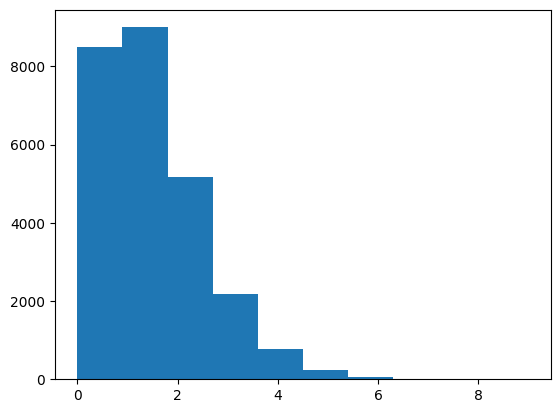

In [69]:
plt.hist(data['away_team_goal_count'])
plt.show()

In [72]:
data['result'] = data.apply(lambda row: 1 if row['home_team_goal_count'] > row['away_team_goal_count'] \
                    else (2 if row['home_team_goal_count'] < row['away_team_goal_count'] else 0), axis=1)

In [76]:
data.columns

Index(['date_GMT', 'attendance', 'home_team_name', 'away_team_name', 'referee',
       'Game Week', 'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'home_ppg',
       'away_ppg', 'home_team_goal_count', 'away_team_goal_count',
       'total_goal_count', 'total_goals_at_half_time',
       'home_team_goal_count_half_time', 'away_team_goal_count_half_time',
       'home_team_goal_timings', 'away_team_goal_timings',
       'home_team_corner_count', 'away_team_corner_count',
       'home_team_yellow_cards', 'home_team_red_cards',
       'away_team_yellow_cards', 'away_team_red_cards',
       'home_team_first_half_cards', 'home_team_second_half_cards',
       'away_team_first_half_cards', 'away_team_second_half_cards',
       'home_team_shots', 'away_team_shots', 'home_team_shots_on_target',
       'away_team_shots_on_target', 'home_team_shots_off_target',
       'away_team_shots_off_target', 'home_team_fouls', 'away_team_fouls',
       'home_team_possession', 'away_team_possession',
       

## Model building - first approach

### Data preparation

In [94]:
model_vars = [
    'home_team_corner_count',
    'away_team_corner_count',
    'home_team_yellow_cards',
    'home_team_red_cards',
    'away_team_yellow_cards',
    'away_team_red_cards',
    'home_team_first_half_cards',
    'home_team_second_half_cards',
    'away_team_first_half_cards',
    'away_team_second_half_cards',
    'home_team_shots',
    'away_team_shots',
    'home_team_shots_on_target',
    'away_team_shots_on_target',
    'home_team_shots_off_target',
    'away_team_shots_off_target',
    'home_team_fouls',
    'away_team_fouls',
    'home_team_possession',
    'away_team_possession',
    'team_a_xg',
    'team_b_xg',
    'odds_ft_home_team_win',
    'odds_ft_draw',
    'odds_ft_away_team_win',
]

In [127]:
X = data[model_vars]
y = data['result']

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20756, 25), (5189, 25), (20756,), (5189,))

### Logistic regression

In [98]:
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [99]:
y_pred = logistic_regression_model.predict(X_test)

In [101]:
accuracy_score(y_test, y_pred)

0.5858546926190017

### Basic MLP

Two output neurons: result and amount of goals scored.

In [131]:
y_goals = data['goals_total']
y_goals_train, y_goals_test = train_test_split(y_goals, test_size=0.2, random_state=42)

In [132]:
y_goals_train.shape, y_goals_test.shape

((20756,), (5189,))

In [138]:
# Definicja warstw wejściowych
input_layer = Input(shape=(25,))

# Warstwa dla przewidywanego wyniku meczu
output_scores = Dense(3, activation='softmax', name='scores_output')(input_layer)

# Warstwa dla przewidywanej liczby goli
output_goals = Dense(1, activation='linear', name='goals_output')(input_layer)

# Tworzenie modelu
model = Model(inputs=input_layer, outputs=[output_scores, output_goals])

# Kompilacja modelu
model.compile(optimizer='adam',
              loss={'scores_output': 'sparse_categorical_crossentropy', 'goals_output': 'mean_squared_error'},
              metrics={'scores_output': 'accuracy'})

In [139]:
y_goals_train.shape

(20756,)

In [140]:
model.fit(X_train, {'scores_output': y_train, 'goals_output': y_goals_train}, epochs=10, batch_size=32)

Epoch 1/10
649/649 [==============================] - 2s 2ms/step - loss: 235.5589 - scores_output_loss: 4.8645 - goals_output_loss: 230.6945 - scores_output_accuracy: 0.3418
Epoch 2/10
649/649 [==============================] - 1s 2ms/step - loss: 30.3011 - scores_output_loss: 1.5211 - goals_output_loss: 28.7801 - scores_output_accuracy: 0.4527
Epoch 3/10
649/649 [==============================] - 1s 2ms/step - loss: 14.0674 - scores_output_loss: 0.9936 - goals_output_loss: 13.0739 - scores_output_accuracy: 0.5420
Epoch 4/10
649/649 [==============================] - 1s 2ms/step - loss: 8.6376 - scores_output_loss: 0.9088 - goals_output_loss: 7.7288 - scores_output_accuracy: 0.5771
Epoch 5/10
649/649 [==============================] - 1s 2ms/step - loss: 6.6117 - scores_output_loss: 0.8954 - goals_output_loss: 5.7163 - scores_output_accuracy: 0.5788
Epoch 6/10
649/649 [==============================] - 1s 2ms/step - loss: 5.4997 - scores_output_loss: 0.8926 - goals_output_loss: 4.6071

In [142]:
# Predykcja na danych testowych
y_pred_scores, y_pred_goals = model.predict(X_test)

# Ocenianie dokładności modelu dla wyników meczu
accuracy_scores = accuracy_score(y_test, np.argmax(y_pred_scores, axis=1))
print("Dokładność modelu dla wyników meczu: {:.2f}%".format(accuracy_scores * 100))

# Ocenianie dokładności modelu dla liczby goli
mse_goals = mean_squared_error(y_goals_test, y_pred_goals)
print("Średni błąd kwadratowy dla liczby goli: {:.2f}".format(mse_goals))

163/163 [==============================] - 0s 2ms/step
Dokładność modelu dla wyników meczu: 58.43%
Średni błąd kwadratowy dla liczby goli: 2.97


### LSTM

In [85]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[0], X_train.shape[1])))
model.add(Dense(3, activation='softmax'))  # Warstwa wyjściowa z trzema neuronami (0, 1, 2)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [86]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


ValueError: in user code:

    File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\anaconda3\envs\magisterka_env\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 20756, 26), found shape=(None, 26)


In [ ]:
model.evaluate(X_test, y_test)